 ## Deep Learning Meets Hyperspectral Image Analysis set

#### Main Goal
During our last year of degree in Statistics we asked to reproduce to following paper:

https://www.sciencedirect.com/science/article/abs/pii/S0169743917306780

Particularly, SAE algorithm and SAE optimization while using AWS-EC2 cloud.
In order to reproduce SAE- deep learning alghorithm we had to learn about the following subjects:
* Neural network
* Deep learning
* SAE algorithm 
* SAE hyperparameters
* SAE hyperparameters optimization
* Talos
* AWS-EC2 api



### Abstract
The paper represent a diffrent ways to predict nitrogen (N) concentration in oilseed rape leaf from hyperspectral imaging . 
We try to reproduce specific algorithm, SAE-FNN10. 
Deep learning (DL) offer a variety of tools to solving hyperspectral imaging tasks. 
AWS-EC2 is useful tool for DL algorithm especially for hyperparameters optimization.


### Workflow
1. Problem Definition.
2. Data loading.
3. Analyze- explore the data.
4. Acquire- training and testing data.
5. Model:
    5.1 Model definition.
    5.2 Hyperparameters optimization.
    5.3 Selected model training.
6. Prediction.
7. Summary and conclusion.




### 1. Problem Definintion:

Predict nitrogen (N) concentration in oilseed rape leaf from hyperspectral imaging.

#### Load packages


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import six.moves.cPickle as pickle
import gzip
import pandas as pd
import matplotlib.ticker as ticker
from keras.layers.advanced_activations import LeakyReLU
import talos as ta
import wrangle as wr
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live
# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense,Dropout
from keras.models import Model, Sequential, save_model, load_model
from keras.callbacks import CSVLogger,ModelCheckpoint
%matplotlib inline
from keras.models import Model
from sklearn.model_selection import train_test_split
import sys
from pandas.core import datetools
from numpy.core.umath_tests import inner1d
from talos.utils.gpu_utils import multi_gpu
from talos.utils.gpu_utils import force_cpu
sys.path.insert(0, '/home/ubuntu/talos/')
import talos as ta
from sklearn.metrics import mean_squared_error, r2_score
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
random.seed(100) # for reproducibility
def rmse(predictions, targets): #RMSE function for model evaluation
    return np.sqrt(((predictions - targets) ** 2).mean())

### 2. Data loading.


In [2]:
###########################################################################################################
#Parameters
###########################################################################################################

train_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_train.pkl.gz"   #train dataset 
validation_dataset="/home/ubuntu/SAE-FNN_Code_Data/data/train_pixels/ramdonpixel_val.pkl.gz"#validation dataset
meanspectrumdataset="/home/ubuntu/SAE-FNN_Code_Data/data/Meanspectra.csv"                   #Mean spectra for each sample in both calibration and testing set


### 3. Analyze- explore the data.

For each sample-nitrogen concentration, spectral data in the
range of 380–1030 nm wavelength with 512 bands of each pixel were taken.

In [3]:
with gzip.open(train_dataset, 'rb') as f:
            train_set1, valid_set1 = pickle.load(f)
with gzip.open(validation_dataset, 'rb') as f:
            train_set2, valid_set2= pickle.load(f)
X=np.concatenate((train_set1[0],train_set2[0],valid_set1[0],valid_set2[0]))
y=np.concatenate((train_set1[1],train_set2[1],valid_set1[1],valid_set2[1]))


### Data visualization

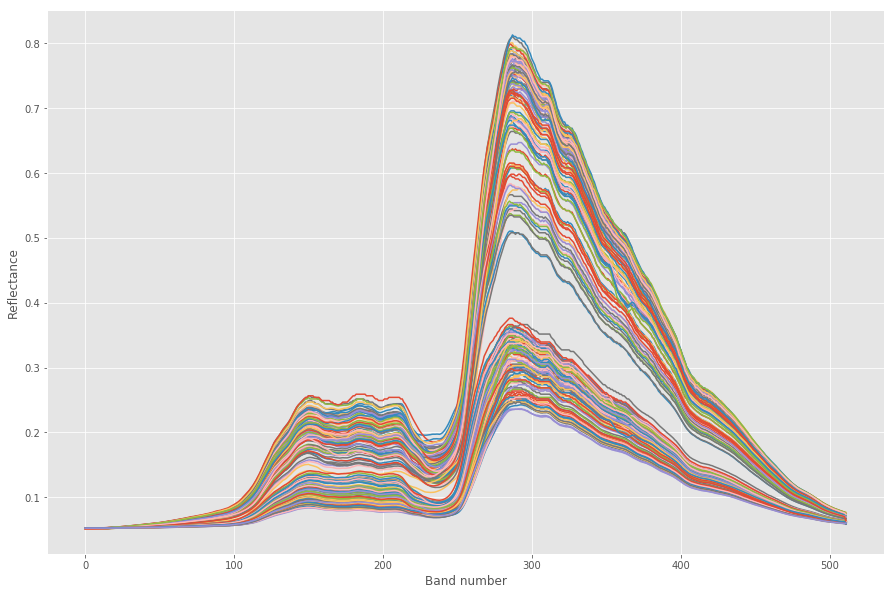

In [5]:
data = pd.read_csv("/home/ubuntu/SAE-FNN_Code_Data/data/Meanspectra.csv")
y=data.iloc[:, 2]
X=data.iloc[:, 3:]
band=range(512)
# Plot spectra
plt.figure(figsize=(15,10))
with plt.style.context(('ggplot')):
    plt.plot(band, X.T)
    plt.xlabel('Band number')
    plt.ylabel('Reflectance')    
plt.show()

 Notice that region of bands 1-120, have moderate change while in the region of bands 250-512 have drastic change of reflectance.
 In addition, in region 250- 300 there are significant difference between each band.



### 4. Acquire- training and testing data.

Splitting the data to train (80%) and test (20%) after shuffling in order to avoid patterns. 

It should be noted that we didn't split to validation set because Talos performing cross validation (k-fold) on the train set.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, shuffle=True )

### 5. Model:

### 5.1 Model defintion

- The core data structure of Keras is a model, a way to organize layers. 
- The simplest type of model is the Sequential model, a linear stack of layers, neural network layers. 
- The sequential API allows as to create models layer-by-layer.


In [6]:
# input: train (70%) and validation (30%) data with grid of paramaters (p)
# output: compiled model and model's data
def model_opti(x_train, y_train, x_val, y_val, params):
    
    #model format
    model = Sequential()
    
    #input layer
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    #this line is used to convey the fact that we wish to tune the activation 
                    #function parameter and find the best fit among 
                    activation=params['activation'],
                    #this line is used to convey the fact that we wish to tune the 
                    #kernel initializer parameter and find the best fit among 
                    kernel_initializer=params['kernel_initializer']))  
    #adding more layers
    #this line is used to convey the fact that we wish to tune the value of the keep probability of 
    #Dropout and find the best fit among the range of real numbers between 0 and 1.(=0)
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    #compiling the model
    #we declare the loss function and the optimizer
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc', fmeasure_acc])
    
    #fitting the model on training data
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

### 5.2 Hyperparameters optimization

### Tuning hyperparamters

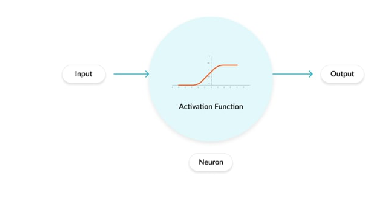

In [76]:
img=mpimg.imread('1.jpg')
plt.imshow(img)
im = Image.open("1.jpg")
im.rotate(45).show()
plt.axis('off')
plt.show(im)

- hidden_layers: Layer in between input layers and output layers, where artificial neurons take in a set of weighted inputs and produce an output through an activation function.
- batch_size: number of patterns shown to the network before the weight matrix is updated. If batch size is less, patterns would be less repeating and hence the weights would be all over the place and convergence would become difficult. If batch size is high learning would become slow as only after many iterations will the batch size change.
- epochs: The number of epochs is the number of times the entire training data is shown to the model. It plays an important role in how well does the model fit on the train data. High number of epochs may over-fit to the data and may have generalization problems on the test and validation set, also they could cause vanishing and exploding gradient problems.





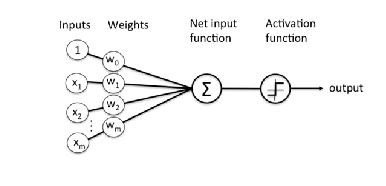

In [71]:
img=mpimg.imread('2.jpg')
plt.imshow(img)
im = Image.open("2.jpg")
im.rotate(45).show()
plt.axis('off')
plt.show(im)

- dropout: The keep-probability of the Dropout layer.
- kernel initializer:  Doesn’t play a very big role but still it is preferred to use normal/uniform initialization while using ReLUs.
- optimizer: It is the algorithm used by the model to update weights of every layer after every iteration. 
- losses: we seek to minimize the error. As such, the objective function is often referred to as a cost function or a loss function and the value calculated by the loss function.

In order to "sense" the best parameters we cahnged the grid range couple of times until we got this practical grid.

presumption that was used: the more epochs the better, until getting overfiting. hence we used a small value of epochs in the tuning section, in the final model we used larger value.

In [7]:
# set the parameter space
p =  {'first_neuron':[7,8,9,10,20],
     'hidden_layers':[3,4,5,10],
     'batch_size': [128],
     'epochs': [20],
     'dropout': [0.5,0.6,0.7,0.8],
     'kernel_initializer': ['normal','uniform'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu,relu],
     'last_activation': ['elu','relu']
}

#### Talos

As we presented earlier, when designing the architecture for an artificial neural network, there exist a variety of parameters that can be tuned.

Just like we have GridSearchCV for hyperparameter optimization within scikit-learn models like Decision Trees, Talos can be applied on Keras models. Talos works similarly to GridSearchCV, by testing all possible combinations of those parameters we have introduced, and chooses the best model, based on what parameter we have asked it to either optimize or reduce (MSE).



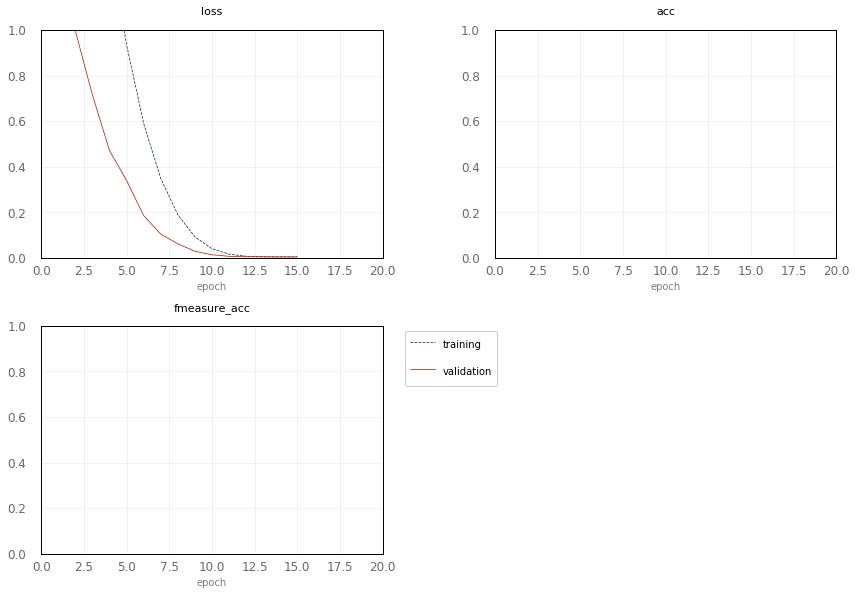

In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with all combinations.
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p,
            dataset_name='talos tutorial',
            experiment_no='1')

The next step is to use the Reporting command to evaluate the experiments. Reporting saves a CSV-file where each experiment is stored with its results (talos tutorial_1.csv). In this file, you can see the rounds_epochs, val_loss, val_accuracy, train loss, test accuracy, activation function, and number of neurons for first and second hidden layer, the optimizer and loss function, batch size, and epochs. 

In [59]:
r = ta.Reporting(t)
# get the best paramaters
print(r.best_params())
accessing the results data frame
print(r.data.head())


[["<class 'keras.optimizers.Adam'>" 'mean_squared_error' 'elu' 'normal'
  '<function elu at 0x7facf535cae8>' 128 11000 8 0.5 5 0]]


By printing the best_params for val_loss, those experiments with the lowest loss value are visualized.
In our case, the combination of the below: 


- First Neurons: 8 
- Number of hidden layers: 5
- Batch size: 128 
- Epochs: We used a small number in order to get fast tune of the model, in the next section we will use large number (11000).
- Dropout: 0.5
- Kernel initializer: normal
- Optimizer: Adam 
- Loss function: MSE 
- Activation function : elu 
- Last activation function : elu 


 


####   5.3 Selected model training.

Using the best hyperparametrs with large epoch number, in order to fine tune the model

In [41]:
# set the parameter space
p2 =  {'first_neuron':[8],
     'hidden_layers':[5],
     'batch_size': [128],
     'epochs': [11000],
     'dropout': [0.5],
     'kernel_initializer': ['normal'],
     'optimizer': [ Adam],
     'losses': ['mean_squared_error'],
     'activation':[elu],
     'last_activation': ['elu']
}

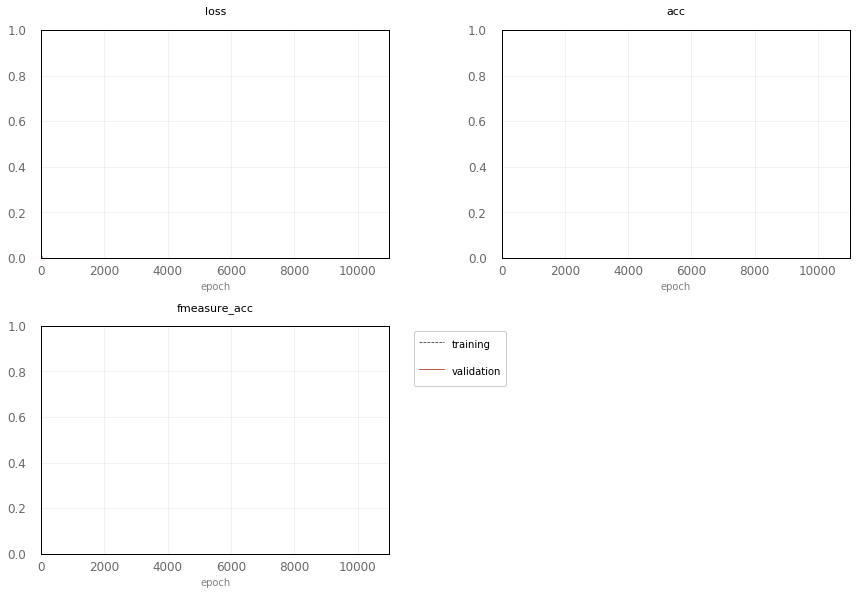

In [ ]:
#input: train set, model settings, hyperparamaters grid
#output: csv file with final combination.
force_cpu()
t = ta.Scan(x=X_train,
            y=y_train,
            model=model_opti,
            params=p2,
            dataset_name='talos tutorial',
            experiment_no='pred')

#### 6. Prediction.
We are now ready to Deploy the model.
Finally we used the SAE model in order to predict the test set.
Deploy command prepares a zip-file that can be transferred to another environment or system. The zip files provides us with information about the experiment in “SAE1_results.csv”, the weights of the model, saved as “SAE1_model.h5, and the model in a json format: “SAE1_model.json”.

In [48]:
ta.Deploy(t, 'SAE1')
SAE1 = ta.Restore('SAE1.zip')


Deploy package SAE1 have been saved.


After we have used the Deploy command, we can get access to the model and use it for Prediction.

In [ ]:
pred=SAE1.model.predict(X_test)

Predication results

In [49]:
rmse_val = rmse(y_test, pred)       #RMSEP
r2_val = r2_score(y_test, pred)     #R2P
RPDp=np.std(y_test)/rmse_val*1.0    #RPDp

print(" prediction r2 is: " + str(r2_val))
print(" prediction rms error is: " + str(rmse_val))
print(" prediction RPDp is: " + str(RPDp))

 prediction r2 is: 0.7526228339979012
 prediction rms error is: 0.03451115359291276
 prediction RPDp is: 2.0105746155044133


### 7. Summary and conclusion.

The results of this study demonstrate that deep learning model was feasible to be used as Hyperspectral imaging data analysis method for N prediction in oilseed rape leaf. 

In addition Talos is a useful package for solving complex neural network models and decide the right combination of the parameters. The best model can be found by running the code one time, instead of running the code after each change of a single parameter. This does save us time, and makes it easier for us to find the best combinations with the lowest loss values. 
 
#### The results (paper results):
$R^2 = 0.752$ (Paper result: 0.903)

$Rmse = 0.0345$ (Paper result: 0.307)

$RPDp = 2.0105$ (Paper result: 3.238)
